# Python for Data Science - Final Project - Team 4
## Performance Analysis of Fast Food Companies in the Stock Market

### Getting Started
This notebook is designed to provide a structured approach to exploring and analyzing the datasets of 10 major fast-food companies.
Each dataset contains daily stock market data with information on opening price, closing price, trading volume, and other financial metrics.

### Objective
The primary goal of this notebook is to perform a comprehensive analysis of the stock market performance of these companies over the years. Through this analysis, we aim to:

1. Understand the structure and content of the datasets
2. Explore key metrics such as price trends, trading volumees, and price spreads
3. Visualize and interrupt important patterns and relationships in the data
4. Summarize insights that reveal the financial dynamics of the fast-food industry

### Dataset Overview
The datasets include the following companies:

- BRK-A: Berkshire Hathaway Inc.
- DNUT: Krispy Kreme, Inc.
- DPZ: Domino’s Pizza, Inc.
- LKNCY: Luckin Coffee Inc.
- MCD: McDonald’s Corporation
- PZZA: Papa John’s International, Inc.
- QSR: Restaurant Brands International, Inc.
- SBUX: Starbucks Corporation
- WEN: The Wendy’s Corporation
- YUM: Yum! Brands, Inc.

Each dataset contains the following columns:

- *Date*: Trading date.
- *Open*: Opening price.
- *High*: Highest price during the session.
- *Low*: Lowest price during the session.
- *Close*: Closing price.
- *Adj Close*: Adjusted closing price (accounting for dividends and stock splits).
- *Volume*: Number of shares traded during the session.

---

# Data Preprocessing Summary

## Preprocessing Steps

1. **Missing Volume Handling**:
   - Replaced missing values in the `Volume` column using a 7-day rolling mean.

2. **Missing Values Imputation**:
   - For columns `['Open', 'High', 'Low', 'Close', 'Adj Close']`:
     - Replaced outliers (Z-score > 3 or < -3) with the rolling median (7-day window).
     - Imputed any remaining missing values using the rolling median.

3. **Erroneous Values Correction**:
   - Checked for rows where `Low >= High`:
     - Replaced `Low` values with a 7-day rolling mean.
     - Ensured that `Low` values do not exceed corresponding `High` values by adjusting `Low` to equal `High` where necessary.

4. **Zero Volume Handling**:
   - For rows where `Volume == 0`:
     - If price columns (`['Open', 'High', 'Low', 'Close']`) had different values, replaced them with the mode (most common value).

5. **Uniform Price Handling**:
   - Identified rows where all price columns (`['Open', 'High', 'Low', 'Close']`) were identical:
     - If `Volume` was NaN, replaced it with `0.0`.

6. **Duplicate Dates Check**:
   - Checked for duplicate dates in the `Date` column:
     - Reported the count of duplicates and displayed duplicate rows if found.
     - If no duplicates, confirmed the absence of duplicate dates.

7. **Output**:
   - Saved the cleaned DataFrame for each ticker into a dictionary (`dfs`) for further analysis.

## Key Points
- Used rolling statistics (mean and median) for robust handling of missing values and outliers.
- Ensured consistency in `Low` and `High` values.
- Imputed `Volume` as `0.0` for rows with identical price columns and missing volume.


In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np

# Adding the files into a list
files=['/Users/danielpace/Downloads/ProjectDatasets-2/Team_4/BRK-A.csv',
       '/Users/danielpace/Downloads/ProjectDatasets-2/Team_4/DNUT.csv',
       '/Users/danielpace/Downloads/ProjectDatasets-2/Team_4/DPZ.csv',
       '/Users/danielpace/Downloads/ProjectDatasets-2/Team_4/LKNCY.csv',
       '/Users/danielpace/Downloads/ProjectDatasets-2/Team_4/MCD.csv',
       '/Users/danielpace/Downloads/ProjectDatasets-2/Team_4/PZZA.csv',
       '/Users/danielpace/Downloads/ProjectDatasets-2/Team_4/QSR.csv',
       '/Users/danielpace/Downloads/ProjectDatasets-2/Team_4/SBUX.csv',
       '/Users/danielpace/Downloads/ProjectDatasets-2/Team_4/WEN.csv',
       '/Users/danielpace/Downloads/ProjectDatasets-2/Team_4/YUM.csv']

i=0

# Step 1: Create a list to store the DataFrames
dfs = {}
tickers = ['BRK-A', 'DNUT', 'DPZ', 'LKNCY', 'MCD', 'PZZA', 'QSR', 'SBUX', 'WEN', 'YUM']

for ticker, file in zip(tickers, files):

    # Step 1: Load the dataset
    df = pd.read_csv(file, index_col=False)

    print(df.isnull().sum())

    print('initialdataset',df.head(16))

    # Handling Missing Volume
    df['Volume'] =df['Volume'].fillna(df['Volume'].rolling(window=7, min_periods=1).mean())

    
    # Impute missing values for each column using rolling mean
    columns_to_impute = ['Open', 'High', 'Low', 'Close', 'Adj Close']
    # Handling Outliers
    for column in columns_to_impute:
        # Calculate mean and standard deviation
        mean = df[column].mean()
        std_dev = df[column].std()

        # Calculate Z-scores
        z_scores = (df[column] - mean) / std_dev

        # Identify outlier indices (Z-score > 3 or < -3)
        outlier_indices = df[np.abs(z_scores) > 3].index

        # Replace outliers with the rolling median
        for idx in outlier_indices:
            df.at[idx, column] = df[column].rolling(window=7, min_periods=1).median().iloc[idx]

        # Fill any remaining missing values with rolling median
        df[column] = df[column].fillna(df[column].rolling(window=7, min_periods=1).median())

   


    # Step 1: Identify rows where Volume == 0
    volume_zero_rows = df['Volume'] == 0

    # Step 2: Apply the logic to each row where Volume is 0
    for index, row in df[volume_zero_rows].iterrows():
        # Step 3: Check if any of Open, High, Low, or Close are different
        values = ['Open', 'High', 'Low', 'Close']
        values_dict = row[values]

        # If any value is different, replace it with the common value
        unique_values = values_dict.unique()
        if len(unique_values) > 1:  # More than one unique value means there is a difference
            common_value = values_dict.mode()[0]  # Find the most common value
            for col in values:
                if row[col] != common_value:
                    df.at[index, col] = common_value  # Replace with the common value


    # Step 1: Identify rows where all price columns are the same
    price_columns = ['Open', 'High', 'Low', 'Close']
    price_same_rows = (df[price_columns].nunique(axis=1) == 1)  # Check if all values are the same across price columns

    # Step 2: Check if Volume is NaN for those rows
    volume_empty_rows = price_same_rows & df['Volume'].isna()

    # Step 3: Replace NaN Volume with 0.0 (in float) for those rows
    df.loc[volume_empty_rows, 'Volume'] = 0.0
  

    print('Finaldataset',df.head(16))

    # Check for duplicate dates
    if 'Date' in df.columns:
        duplicate_dates = df['Date'].duplicated().sum()
        if duplicate_dates > 0:
            print(f"There are {duplicate_dates} duplicate date(s).")
            print("Duplicate rows:")
            print(df[df['Date'].duplicated(keep=False)])
        else:
            print("No duplicate dates found.")
    else:
        print("The column 'Date' does not exist in the DataFrame.")
    
    # Drop duplicate rows and count them
    initial_row_count = len(df)
    df = df.drop_duplicates()
    duplicates_dropped = initial_row_count - len(df)

    print(f"{duplicates_dropped} duplicate row(s) were dropped.")

    # Drop duplicates based on 'Date' column (if applicable)
    if 'Date' in df.columns:
        initial_row_count = len(df)
        df = df.drop_duplicates(subset='Date', keep='first')
        duplicates_dropped = initial_row_count - len(df)

        print(f"{duplicates_dropped} duplicate date(s) were dropped.")

    # Step 1: Check for rows where Low >= High
    erroneous_rows = df['Low'] >= df['High']

    # Step 2: Replace erroneous Low values with the column's rolling average
    low_avg = df['Low'].rolling(window=7, min_periods=1).mean()

    # Replace Low values where Low >= High
    df.loc[erroneous_rows, 'Low'] = low_avg[erroneous_rows]

    # Step 3: Ensure Low does not exceed High after correction
    df.loc[df['Low'] >= df['High'], 'Low'] = df['High']


    dfs[ticker]=df
 

Date           0
Open         548
High         550
Low          550
Close        550
Adj Close    544
Volume       561
dtype: int64
initialdataset           Date   Open          High           Low  Close     Adj Close  \
0   1980-03-17  290.0  3.100000e+02  2.900000e+02  290.0  2.900000e+02   
1   1980-03-18  290.0  2.900000e+02  2.900000e+02  290.0  2.900000e+02   
2   1980-03-19  290.0  3.100000e+02  2.900000e+02  290.0  2.900000e+02   
3   1980-03-20  290.0  2.900000e+02  2.900000e+02  290.0  2.900000e+02   
4   1980-03-21  290.0  2.900000e+02  2.900000e+02  290.0  2.900000e+02   
5   1980-03-24  290.0  2.900000e+02  2.700000e+02  270.0           NaN   
6   1980-03-25  270.0  2.700000e+02  2.700000e+02  270.0  2.700000e+02   
7   1980-03-26  270.0  2.700000e+02  2.700000e+02  270.0  2.700000e+02   
8   1980-03-27  270.0  2.700000e+02  2.700000e+02  270.0  2.700000e+02   
9   1980-03-28  270.0  2.700000e+02  2.700000e+02  270.0  2.700000e+02   
10  1980-03-31  270.0  2.800000e+02  2.

# **EXERCISE 1**  
---

## 📝 **Description**  

### **1: For Each Dataset**  
- **Print the number of rows and columns**  
- **Display the column names and their data types**  
🎉



In [2]:
import pandas as pd

# Assuming `dfs` is a dictionary where keys are tickers and values are DataFrames
tickers = ['BRK-A', 'DNUT', 'DPZ', 'LKNCY', 'MCD', 'PZZA', 'QSR', 'SBUX', 'WEN', 'YUM']

summary = []

# Iterate over the tickers and their corresponding DataFrames in the dfs dictionary
for ticker in tickers:
    print(f"--- Processing Dataset for {ticker} ---")
    
    if ticker in dfs:  # Check if the ticker exists in the `dfs` dictionary
        df = dfs[ticker]  # Get the preprocessed DataFrame
        
        # Get the number of rows and columns
        num_rows, num_cols = df.shape
        
        # Get the column data types
        column_info = df.dtypes.to_dict()
        
        # Append the information to the summary list
        summary.append({
            'Ticker': ticker,
            'Rows': num_rows,
            'Columns': num_cols,
            'Column Info': column_info
        })
        
        # Print dataset info
        print(f"Number of rows: {num_rows}")
        print(f"Number of columns: {num_cols}\n")
        
        print("Column Names and Data Types:")
        print(column_info)
    else:
        print(f"Data for {ticker} not found in `dfs`.")
    print("\n")

# Create a DataFrame from the summary list
summary_df = pd.DataFrame(summary)

# Save the summary to a CSV file
summary_df.to_csv('dataset_summary.csv', index=False)

# Display the summary DataFrame
print(summary_df)


--- Processing Dataset for BRK-A ---
Number of rows: 11222
Number of columns: 7

Column Names and Data Types:
{'Date': dtype('O'), 'Open': dtype('float64'), 'High': dtype('float64'), 'Low': dtype('float64'), 'Close': dtype('float64'), 'Adj Close': dtype('float64'), 'Volume': dtype('float64')}


--- Processing Dataset for DNUT ---
Number of rows: 810
Number of columns: 7

Column Names and Data Types:
{'Date': dtype('O'), 'Open': dtype('float64'), 'High': dtype('float64'), 'Low': dtype('float64'), 'Close': dtype('float64'), 'Adj Close': dtype('float64'), 'Volume': dtype('float64')}


--- Processing Dataset for DPZ ---
Number of rows: 5083
Number of columns: 7

Column Names and Data Types:
{'Date': dtype('O'), 'Open': dtype('float64'), 'High': dtype('float64'), 'Low': dtype('float64'), 'Close': dtype('float64'), 'Adj Close': dtype('float64'), 'Volume': dtype('float64')}


--- Processing Dataset for LKNCY ---
Number of rows: 1345
Number of columns: 7

Column Names and Data Types:
{'Date': 

# **EXERCISE 2**  
---

## 📝 **Description**  

### **2: Extract Rows for 2023**  
- **Filter all rows where the date is in the year 2023**  
- **Print the number of rows**  
- **Visualize the Close price trend for this period**  
🎉


--- Processing Dataset for BRK-A ---


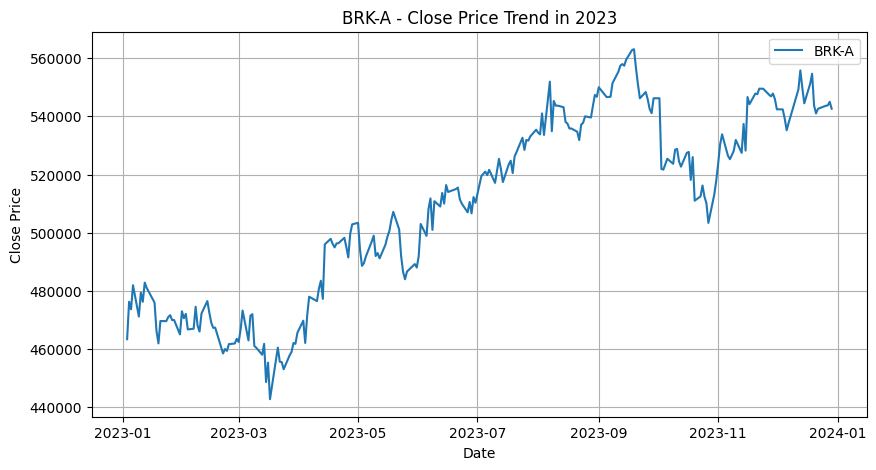



--- Processing Dataset for DNUT ---


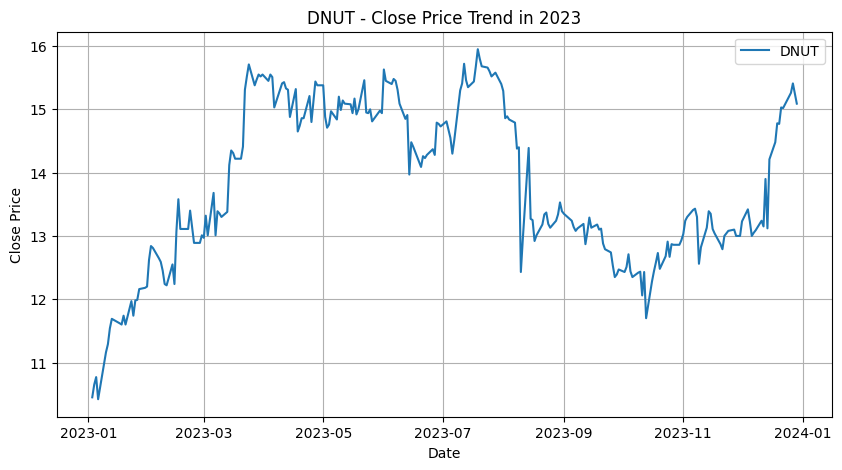



--- Processing Dataset for DPZ ---


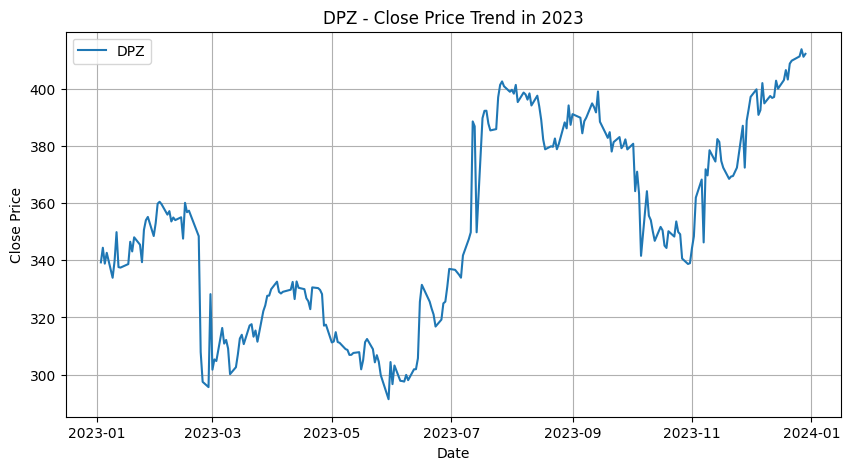



--- Processing Dataset for LKNCY ---


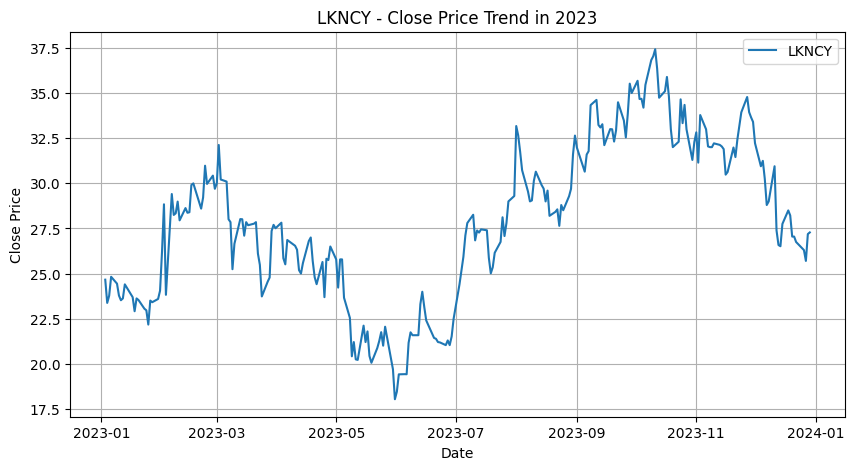



--- Processing Dataset for MCD ---


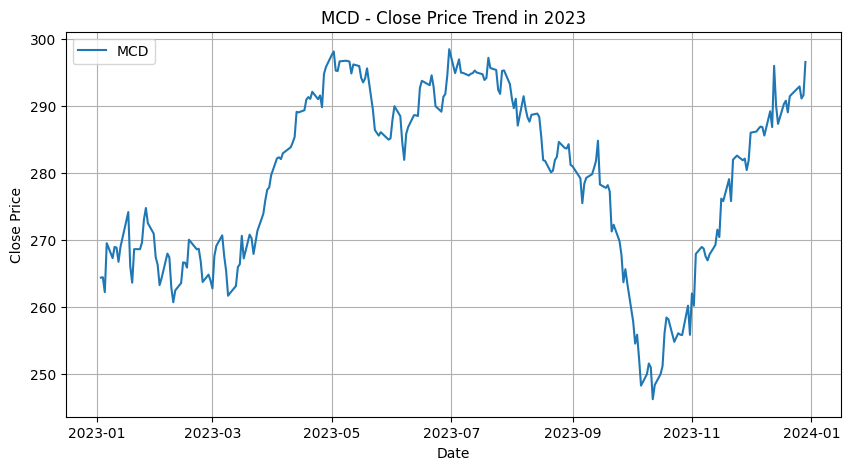



--- Processing Dataset for PZZA ---


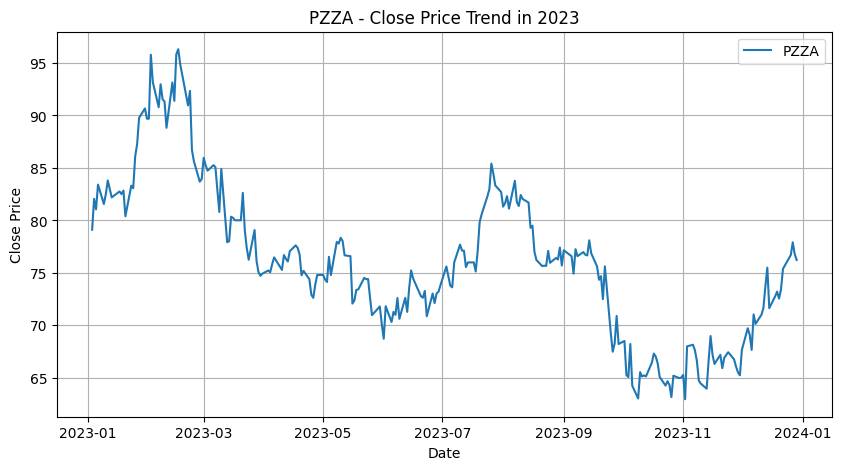



--- Processing Dataset for QSR ---


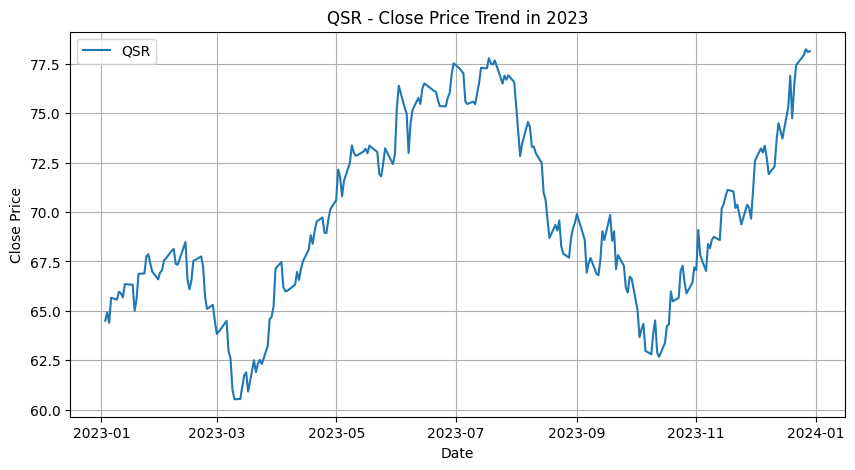



--- Processing Dataset for SBUX ---


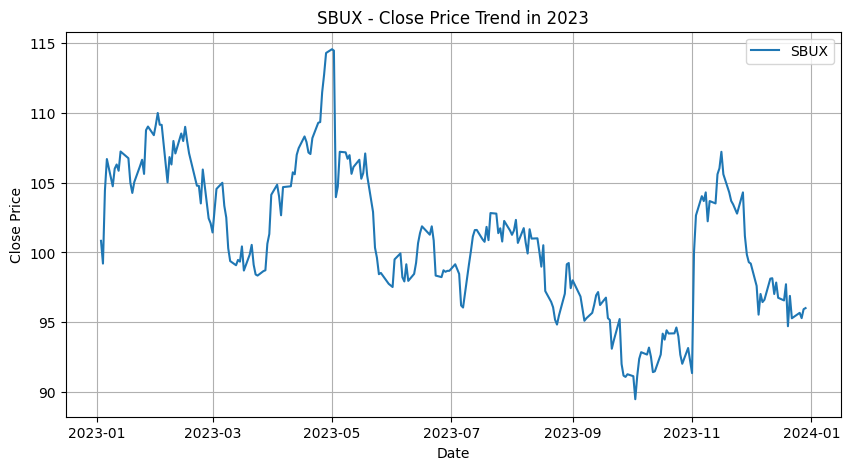



--- Processing Dataset for WEN ---


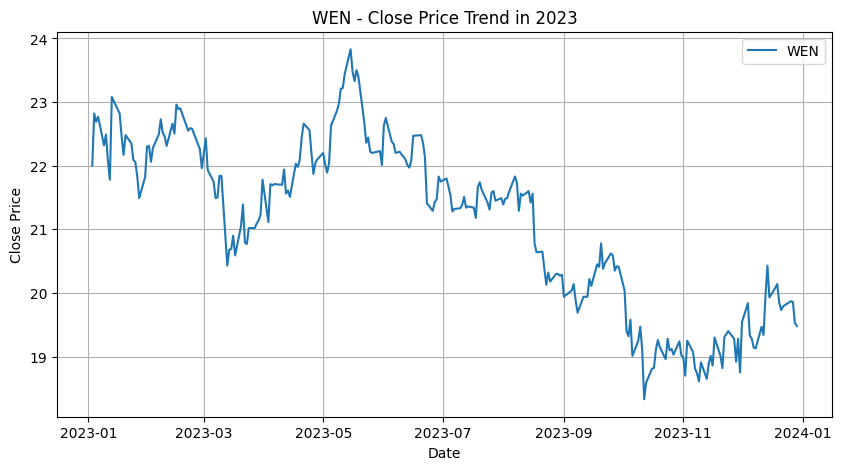



--- Processing Dataset for YUM ---


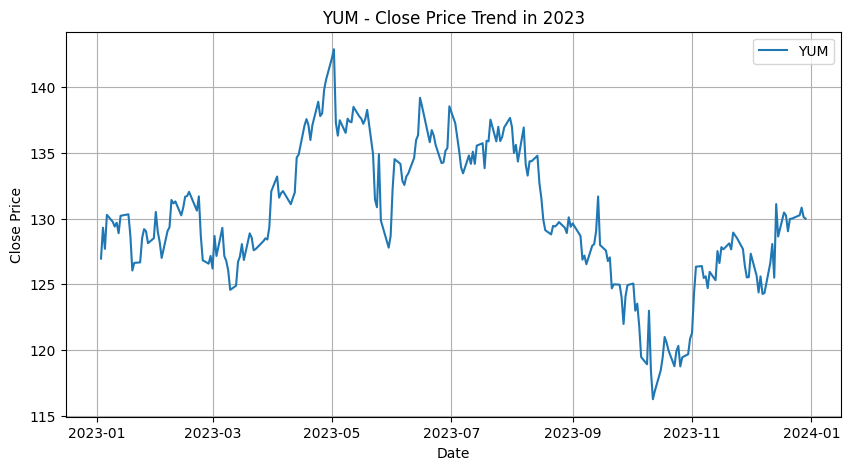



  Ticker  Rows in 2023
0  BRK-A           250
1   DNUT           250
2    DPZ           250
3  LKNCY           250
4    MCD           250
5   PZZA           250
6    QSR           250
7   SBUX           250
8    WEN           250
9    YUM           250


In [3]:
import matplotlib.pyplot as plt

# List to store the summary for 2023
summary_2023 = []

def filter_and_plot_2023(df, ticker):
    # Ensure the 'Date' column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    
    # Filter the data for the year 2023
    df_2023 = df[df['Date'].dt.year == 2023]
    
    # Append the number of rows for 2023 to the summary list
    summary_2023.append({'Ticker': ticker, 'Rows in 2023': len(df_2023)})
    
    # If data for 2023 exists, plot the Close Price trend
    if not df_2023.empty:
        plt.figure(figsize=(10, 5))
        plt.plot(df_2023['Date'], df_2023['Close'], label=ticker)
        plt.title(f"{ticker} - Close Price Trend in 2023")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.legend()
        plt.grid(True)
        plt.show()

# Iterate through the tickers and their corresponding DataFrames in the dfs dictionary
for ticker in tickers:
    print(f"--- Processing Dataset for {ticker} ---")
    
    if ticker in dfs:  # Check if the ticker exists in the dfs dictionary
        df = dfs[ticker]  # Get the preprocessed DataFrame
        
        # Call the function to filter and plot data for 2023
        filter_and_plot_2023(df, ticker)
    else:
        print(f"Data for {ticker} not found in `dfs`.")
    print("\n")

# Convert the summary of rows for 2023 to a DataFrame
summary_2023_df = pd.DataFrame(summary_2023)

# Save the summary to a CSV file
summary_2023_df.to_csv('summary_2023_rows.csv', index=False)

# Display the summary DataFrame
print(summary_2023_df)


# **EXERCISE 3**  
---

## 📝 **Description**  

### **3: Find the Day with Highest Close Price**  
- **For each company, identify the day with the highest Close price**  
- **Display the date and the corresponding Close price**  
🎉


In [4]:
highest_close_summary = []

for ticker in tickers:
    print(f"--- Processing Dataset for {ticker} ---")
    
    # Access the preprocessed DataFrame from the `dfs` dictionary
    if ticker in dfs:
        df = dfs[ticker]  # Get the DataFrame for the ticker

        # Ensure the 'Date' column is in datetime format
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

        # Check if the 'Close' column exists
        if 'Close' in df.columns:
            # Find the row with the highest Close price
            highest_close_row = df.loc[df['Close'].idxmax()]

            # Append the result to the summary list
            highest_close_summary.append({
                'Ticker': ticker,
                'Date': highest_close_row['Date'],
                'Highest Close Price': highest_close_row['Close']
            })

            # Print the highest Close price and corresponding date
            print(f"Highest Close Price for {ticker}: {highest_close_row['Close']} on {highest_close_row['Date']}")
        else:
            print(f"'Close' column not found in {ticker} data.") 
    else:
        print(f"Data for {ticker} not found in `dfs`.")

    print("\n")

# Convert the summary of highest close prices into a DataFrame
highest_close_df = pd.DataFrame(highest_close_summary)

# Save the summary to a CSV file
highest_close_df.to_csv('highest_close_summary.csv', index=False)

# Display the summary DataFrame
print(highest_close_df)


--- Processing Dataset for BRK-A ---
Highest Close Price for BRK-A: 715910.0 on 2024-09-03 00:00:00


--- Processing Dataset for DNUT ---
Highest Close Price for DNUT: 21.0 on 2021-07-01 00:00:00


--- Processing Dataset for DPZ ---
Highest Close Price for DPZ: 564.3300170898438 on 2021-12-31 00:00:00


--- Processing Dataset for LKNCY ---
Highest Close Price for LKNCY: 48.52999877929688 on 2020-01-16 00:00:00


--- Processing Dataset for MCD ---
Highest Close Price for MCD: 300.5299987792969 on 2024-01-19 00:00:00


--- Processing Dataset for PZZA ---
Highest Close Price for PZZA: 140.00999450683594 on 2021-11-04 00:00:00


--- Processing Dataset for QSR ---
Highest Close Price for QSR: 82.75 on 2024-03-13 00:00:00


--- Processing Dataset for SBUX ---
Highest Close Price for SBUX: 126.05999755859376 on 2021-07-26 00:00:00


--- Processing Dataset for WEN ---
Highest Close Price for WEN: 63.3963421596517 on 1980-05-07 00:00:00


--- Processing Dataset for YUM ---
Highest Close Price f

# **EXERCISE 4**  
---

## 📝 **Description**  

### **4: Monthly Average Close Price Analysis**  
- **Group the data by month and calculate the average Close price for each company**  
- **Plot these monthly averages for 3 companies and compare them**  
- **Justify the chart selection**  
🎉


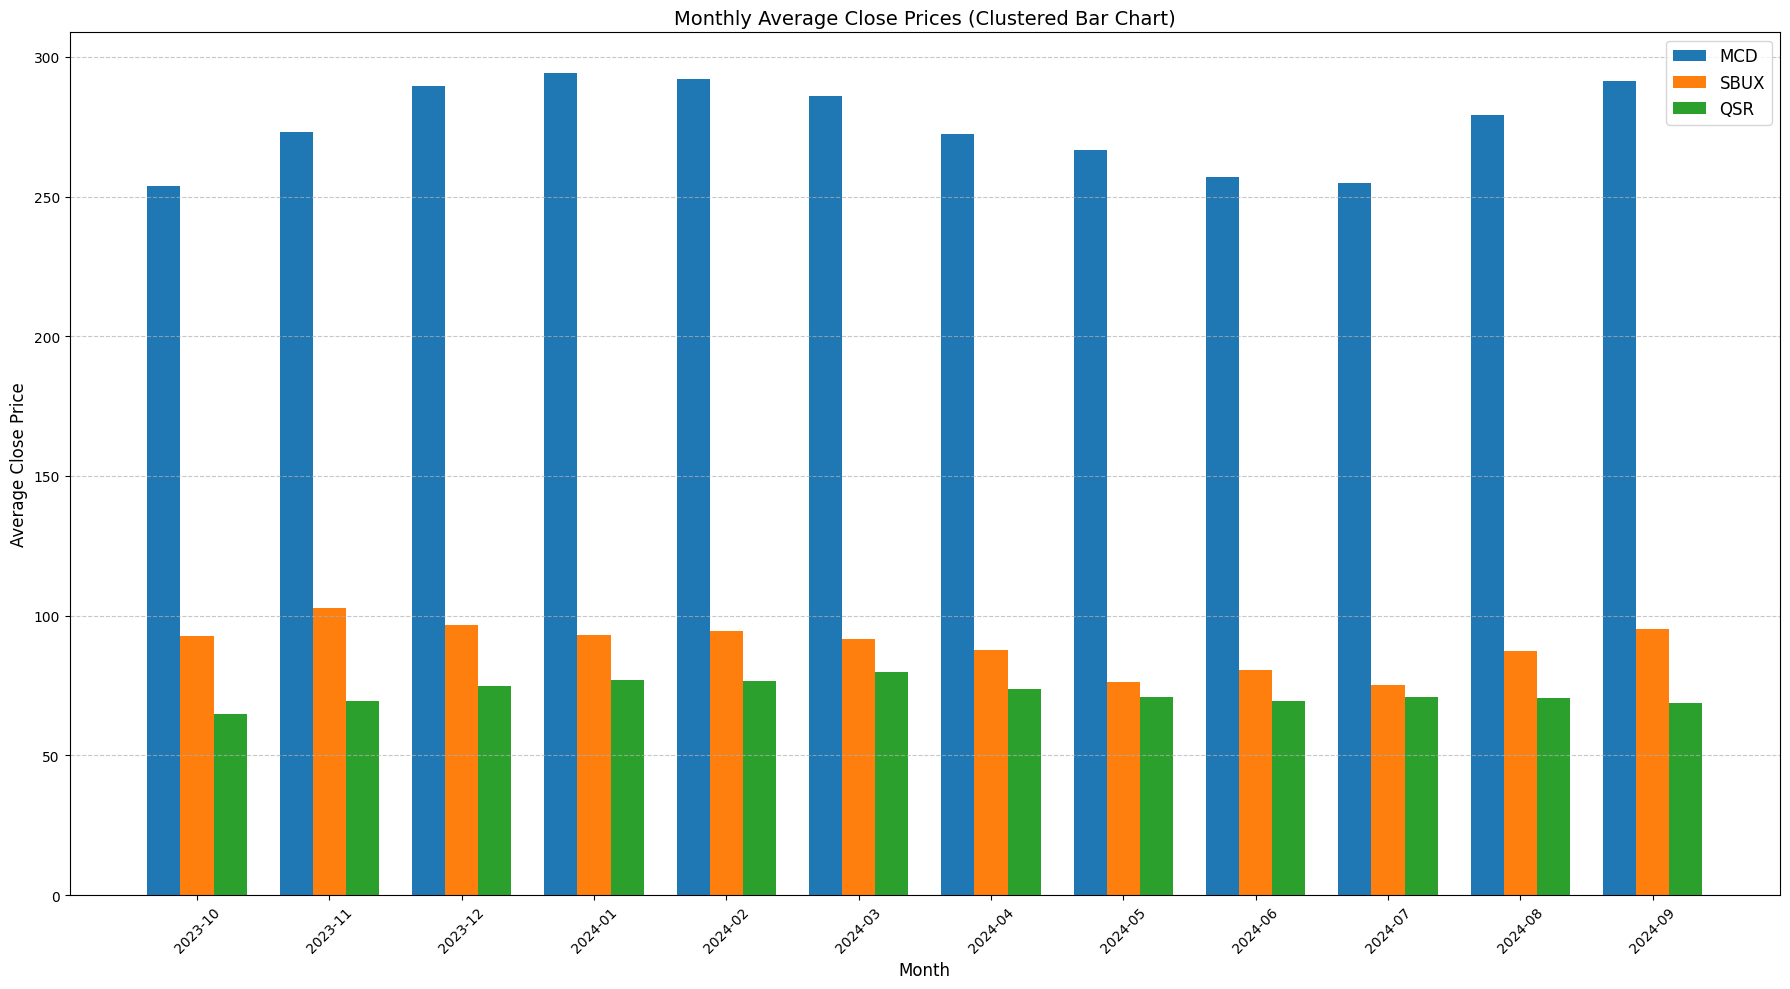

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assume dfs is a dictionary containing the preprocessed DataFrames for each ticker
tickers = ['BRK-A', 'DNUT', 'DPZ', 'LKNCY', 'MCD', 'PZZA', 'QSR', 'SBUX', 'WEN', 'YUM']

monthly_averages = {}

# Process the preprocessed DataFrames for each ticker in dfs
for ticker in tickers:
    if ticker in dfs:
        df = dfs[ticker]  # Access the preprocessed DataFrame for the ticker
        
        # Ensure 'Date' is in datetime format
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        
        if 'Close' in df.columns:
            # Create a new column for the month and year
            df['Month'] = df['Date'].dt.to_period('M')
            
            # Group by the 'Month' column and calculate the average 'Close' price for each month
            monthly_avg = df.groupby('Month')['Close'].mean()
            
            # Store the result in the monthly_averages dictionary
            monthly_averages[ticker] = monthly_avg
        else:
            print(f"'Close' column not found in dataset for {ticker}.")
    else:
        print(f"Data for {ticker} not found in `dfs`.")

# Select specific tickers for comparison
selected_tickers = ['MCD', 'SBUX', 'QSR']

# Create a DataFrame for the selected tickers
comparison_df = pd.DataFrame({ticker: monthly_averages[ticker] for ticker in selected_tickers}).fillna(0)

# Get the last 12 months for comparison
comparison_df = comparison_df.tail(12)

# Plot the data as a clustered bar chart
fig, ax = plt.subplots(figsize=(18, 10))
bar_width = 0.25
x = np.arange(len(comparison_df.index))

# Plot bars for each ticker
for i, ticker in enumerate(selected_tickers):
    ax.bar(
        x + i * bar_width,
        comparison_df[ticker],
        width=bar_width,
        label=ticker
    )

# Set the x-axis labels and other plot settings
ax.set_xticks(x + bar_width)
ax.set_xticklabels(comparison_df.index.astype(str), rotation=45, fontsize=10)

ax.set_title("Monthly Average Close Prices (Clustered Bar Chart)", fontsize=14)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Average Close Price", fontsize=12)
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


# **EXERCISE 5**  
---

## 📝 **Description**  

### **5: Yearly Average Close Price Comparison**  
- **For each company:**  
  - **Compute the yearly average of the Close price**  
  - **Plot a comparison of yearly averages for all companies on a chart**  
- **Justify your chart selection**  
🎉


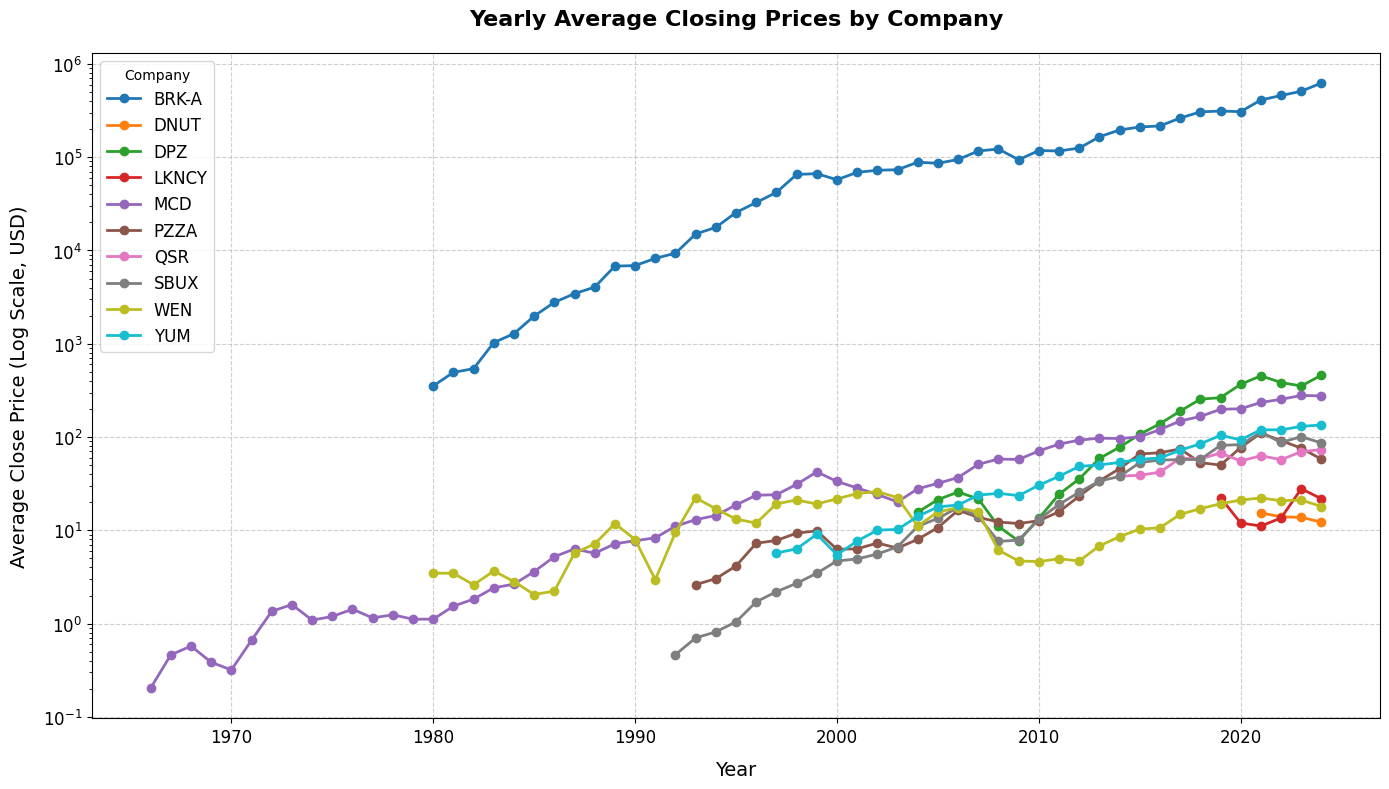

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Initialize a dictionary to store yearly average closing prices for each company
company_yearly_averages = {}

# Process each preprocessed DataFrame in the dfs dictionary
for company_name, df in dfs.items():
        # Ensure the Date column is in datetime format
        df['Date'] = pd.to_datetime(df['Date'])
        
        # Extract the year from the Date column
        df['Year'] = df['Date'].dt.year
        
        # Calculate the yearly average of the 'Close' prices
        yearly_average = df.groupby('Year')['Close'].mean()
        
        # Store the results in the dictionary
        company_yearly_averages[company_name] = yearly_average

# Combine all company data into a single DataFrame for visualization
yearly_average_df = pd.DataFrame(company_yearly_averages)

# Plot the data: Yearly Average Close Prices
plt.figure(figsize=(14, 8))  # Set figure size
plt.title("Yearly Average Closing Prices by Company", fontsize=16, fontweight='bold', pad=20)

# Plot each company's yearly average closing prices
for company in yearly_average_df.columns:
    plt.plot(yearly_average_df.index, yearly_average_df[company], marker='o', linewidth=2, label=company)

# Use a logarithmic scale for the y-axis to address large differences in values
plt.yscale('log')

# Customize the x-axis and y-axis
plt.xlabel("Year", fontsize=14, labelpad=10)
plt.ylabel("Average Close Price (Log Scale, USD)", fontsize=14, labelpad=10)

# Add gridlines
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Add a legend for company names
plt.legend(title="Company", loc="upper left", fontsize=12)

# Enhance x-axis and y-axis ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

## Line Chart Suitability:

Line charts are perfect for displaying trends over time, which aligns with the objective of comparing yearly average close prices for multiple companies.
The use of lines connecting data points emphasizes the continuity and progression of average prices year over year.
Logarithmic Scale Justification:

A logarithmic scale on the y-axis is ideal when there are large differences in the values of the companies' closing prices. It ensures that smaller values are still visible and comparable alongside larger values, avoiding distortion in the visualization.
This choice prevents dominant values from overshadowing smaller trends, allowing for a fair comparison across all companies.
Comparison Across Companies:

The individual lines for each company with distinct markers make it easy to compare their yearly trends while maintaining clarity and avoiding clutter.
Visualization Enhancements:

The addition of a grid, distinct markers, and a legend aids in readability and clarity, allowing the audience to distinguish between the companies easily.
Titles, axis labels, and formatted ticks ensure the plot is professional and understandable for non-expert viewers.
Alternative Chart Consideration:

While a grouped bar chart could also be used, it would not effectively convey the trend over time. The line chart, on the other hand, captures the temporal changes more dynamically.